# Домашнее задание «Элементарные методы анализа временных рядов»

***Цель:***
    Взять из прошлого домашнего задания ряд и построить модель ARIMA/GARCH. Попробовать спрогнозировать график классическим ML

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
from matplotlib.pyplot import figure
from arch import arch_model
%matplotlib inline

In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

Для данной задачи возьмем ряд degrees - "Среднемесячная температура воздуха в окрестностях Ноттингемского замка, в фаренгейтах":

In [3]:
degrees = pd.read_csv("C:/Users/User/PycharmProjects/Netology/Time series/Series/mean-monthly-air-temperature-deg.csv")
degrees.head()

,Month,Deg
0,1920-01,40.6
1,1920-02,40.8
2,1920-03,44.4
3,1920-04,46.7
4,1920-05,54.1


In [4]:
degrees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   240 non-null    object 
 1   Deg     240 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB


Посмотрим на файл:

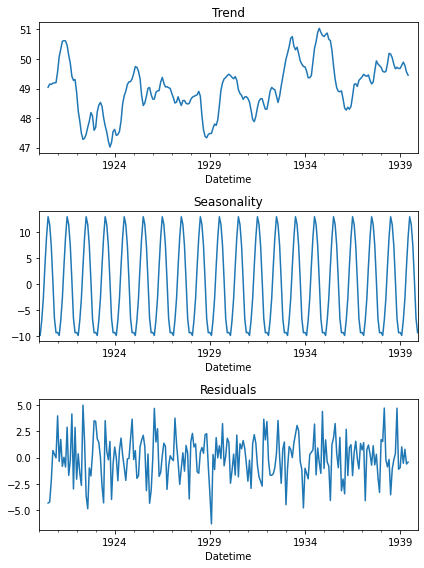

In [5]:
# подготовка к работе:
degrees['Datetime'] = pd.to_datetime(degrees['Month'])
degrees = degrees.set_index('Datetime')
degrees = degrees.drop('Month', axis=1)

# Теперь разложим ряд на тренд, сезонную компоненту и остаток.

decomposed = seasonal_decompose(degrees)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()
plt.show()

У ряда нет четко выраженного тренда (хотя он вполне может быть), но очевидна сезонность, а остатки хаотичны.

Теперь воспроизведем функции для графика Дики-Фуллера и графиков коррелограмм:

In [6]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Поработаем с дисперсией:

Results of Dickey-Fuller Test:
Test Statistic                  -3.760996
p-value                          0.003333
#Lags Used                      15.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


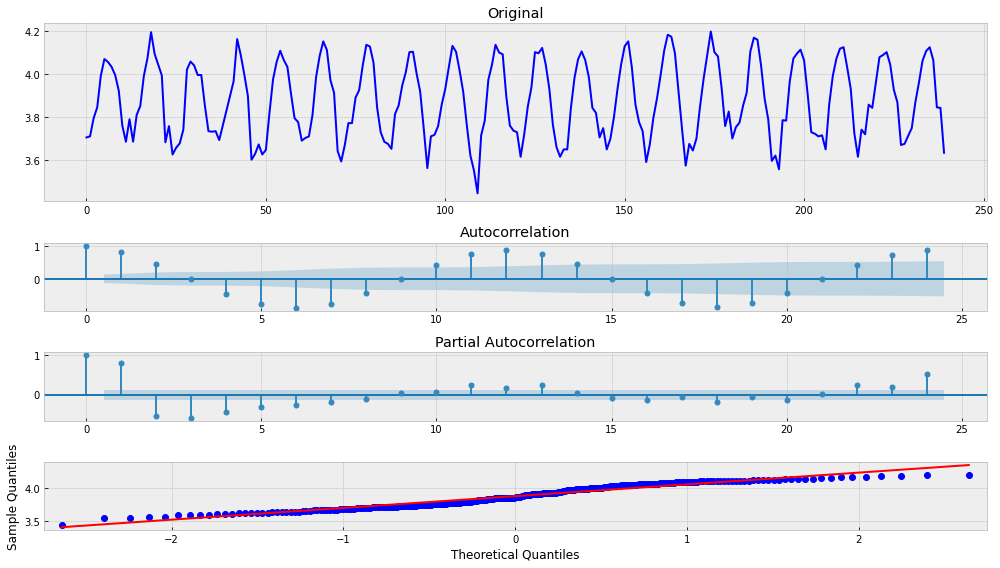

In [7]:
tsplot(boxcox(degrees['Deg'], 0))

Итак, несмотря на наличие сезонности мы можем отвергнусть гипотезу о нестационарности ряда. Однако явно видны хвосты на графике QQplot.    
Также стоит отметить, что мы можем сделать ряд еще более стационарным, применив операции дифференцирования. Поскольку в ARIMA "дифференцирование" (в количестве d-раз) уже заложено непосредственно в саму модель, переходим к заданию 1:

1. Построим модель ***ARIMA***:

aic: 1147.03503 | order: (2, 1, 4)
Results of Dickey-Fuller Test:
Test Statistic                -6.282151e+00
p-value                        3.773556e-08
#Lags Used                     5.000000e+00
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


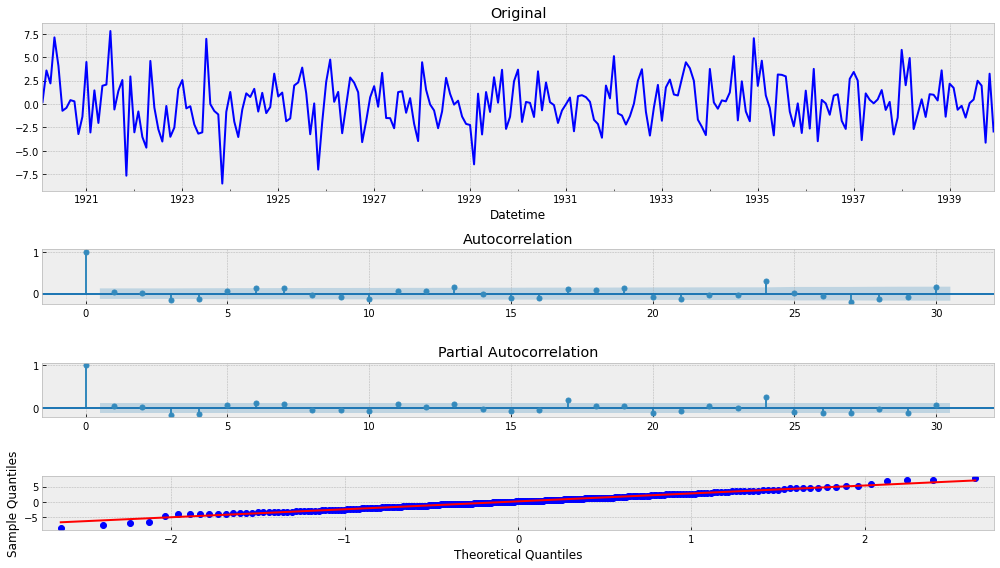

In [8]:
best_aic = np.inf   # на старте нам неизвестно лучшее значение, поэтому ставим бесконечность
best_order = None
best_mdl = None

for i in range(5):   # порядок у модели AR
    for d in range(5):   # сколько раз будем дифференцировать
        for j in range(5):  # порядок у модели MA
            try:
                tmp_mdl = smt.ARIMA(degrees, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic     # получаем новое значение информационного критерия Акаике
                if tmp_aic < best_aic:   # если значение меньше, чем текущее лучшее, заносим его в ответ
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

Итак, что можно сказать: лучшая модель имеет вид order: (2, 1, 4). На графиках остатков видно, что не всё модель смогла поймать: есть немного диперсии в начале ряда. Детальнее это можно рассмотреть на графике QQplot - там явно видны выбросы слева и справа, но справа всё-таки значения ложатся ближе к прямой, поэтому стоит взять во внимание именно выбросы слева.  
Также судя по графику автокорреляции, сезонность не была до конца моделью исключена.  
Теперь попробуем построить прогноз:

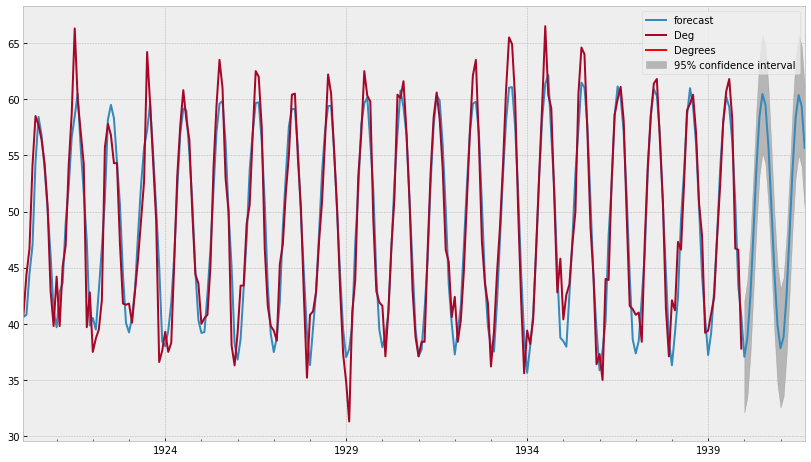

In [9]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(1, len(degrees)+20, ax=ax)
    plt.plot(degrees, color='red', label='Degrees')
    plt.legend()
    plt.show()

Предсказание получилось довольно правдоподобным. Модель довольно точно показаkа 95% доверительный интервал, в котором высока вероятность получить значения в перспективе.  

Теперь попробуем учитывать сезонность. Возьмем модель SARIMA:

aic: 1046.98740 | order: (3, 0, 3)
Results of Dickey-Fuller Test:
Test Statistic                  -3.971996
p-value                          0.001564
#Lags Used                       0.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


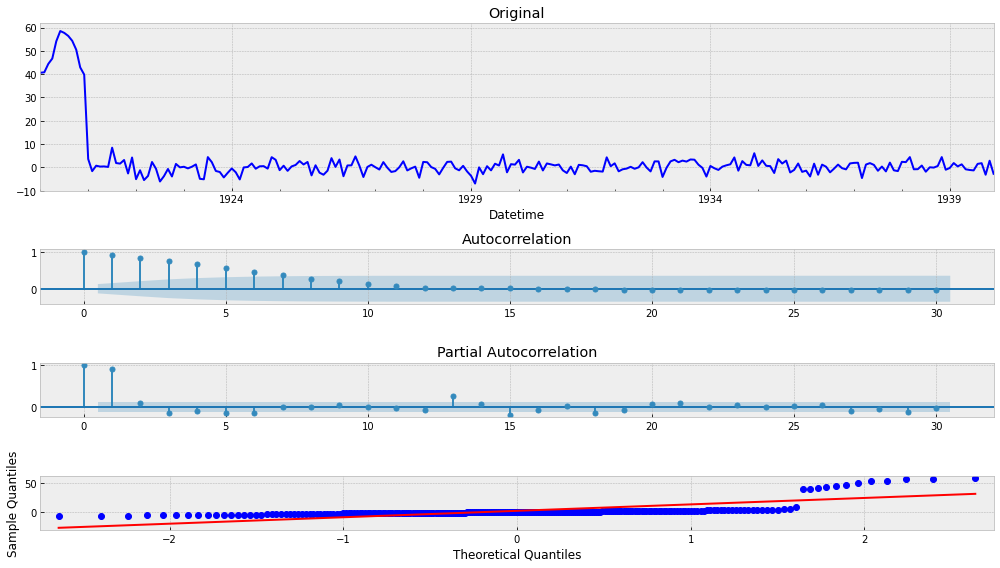

In [10]:
best_aic = np.inf   
best_order = None
best_mdl_sarima = None

for i in range(5):   
    for d in range(5):   
        for j in range(5):  
            try:
                tmp_mdl = sm.tsa.SARIMAX(degrees, trend='n', order=(i,d,j), seasonal_order=(0,1,1,12)).fit()
                tmp_aic = tmp_mdl.aic     
                if tmp_aic < best_aic:  
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl_sarima = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl_sarima.resid, lags=30)

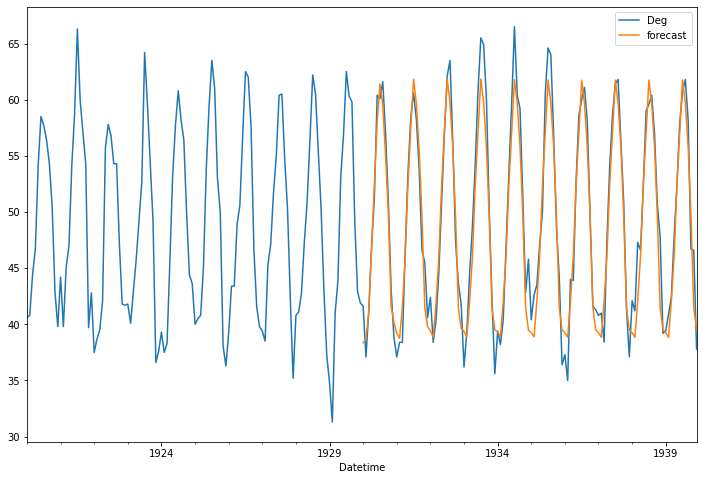

In [11]:
d = degrees
d['forecast'] = best_mdl_sarima.predict(120, len(degrees), dynamic= True)  
d[['Deg', 'forecast']].plot(figsize=(12, 8))
plt.show()

In [12]:
degrees = degrees.drop('forecast', axis=1)

Стало несколько хуже, хотя на более поздних дата присутствует практически полное наложение реальных и предсказанных значений. Однако, вероятно, эта модель не очень подходит для нашего ряда.

Посмотрим на ***GARCH***:

Сперва подготовим данные, потому как в данном случае стоит сделать ряд несколько более стационарным:

Results of Dickey-Fuller Test:
Test Statistic                  -3.760996
p-value                          0.003333
#Lags Used                      15.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


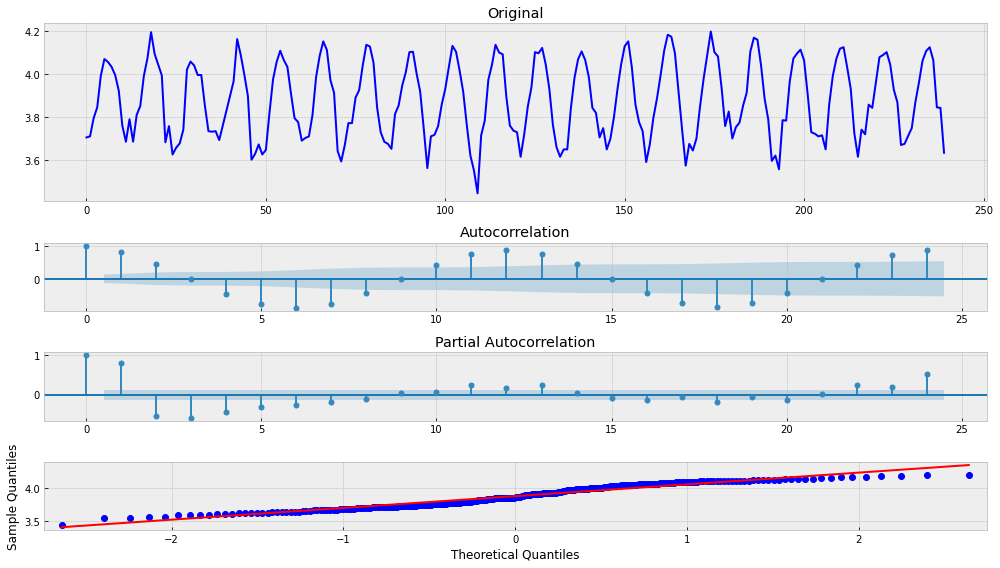

In [13]:
d_new = boxcox(degrees['Deg'], 0)   # сделаем преобразование Бокса-Кокса
tsplot(d_new)

In [14]:
d_new = d_new[12:] - d_new[:-12] # и уберем тренд и сезонность
d_new = d_new[1:] - d_new[:-1]

In [15]:
am = arch_model(d_new, p=2, o=1, q=4, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                209.519
Distribution:      Standardized Student's t   AIC:                          -399.037
Method:                  Maximum Likelihood   BIC:                          -364.788
                                              No. Observations:                  227
Date:                      Mon, May 31 2021   Df Residuals:                      226
Time:                              19:07:21   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

Results of Dickey-Fuller Test:
Test Statistic                -7.999033e+00
p-value                        2.361164e-12
#Lags Used                     1.500000e+01
Number of Observations Used    2.110000e+02
Critical Value (1%)           -3.461727e+00
Critical Value (5%)           -2.875337e+00
Critical Value (10%)          -2.574124e+00
dtype: float64


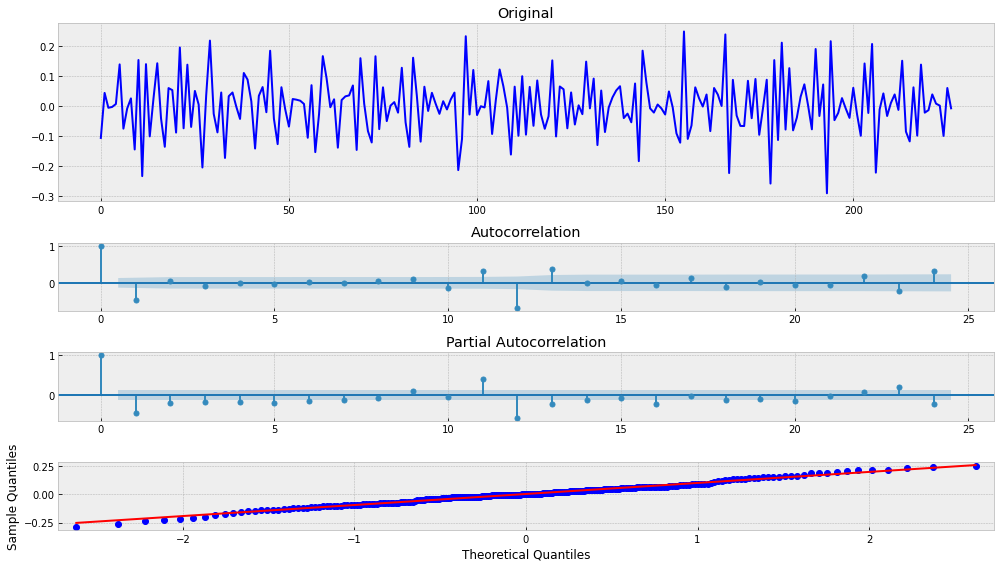

In [16]:
tsplot(res.resid)

Результат тоже получился правдоподобный. Значения лежат на прямой на графике QQplot, а распределение остатков говорит о том, что мы смогли получить всю информацию. Соответственно, именно GARCH на этом наборе данных предсказывает точнее.

2. Переходим к классике.  
Построим модель ***линейной регрессии***:

In [17]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Deg.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Datetime"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Deg"], axis=1)
    y_train = data.loc[:test_index]["Deg"]
    X_test = data.loc[test_index:].drop(["Deg"], axis=1)
    y_test = data.loc[test_index:]["Deg"]
    
    return X_train, X_test, y_train, y_test

In [18]:
X_train, X_test, y_train, y_test = prepareData(degrees.reset_index(), lag_start=1, lag_end=20, test_size=0.3)

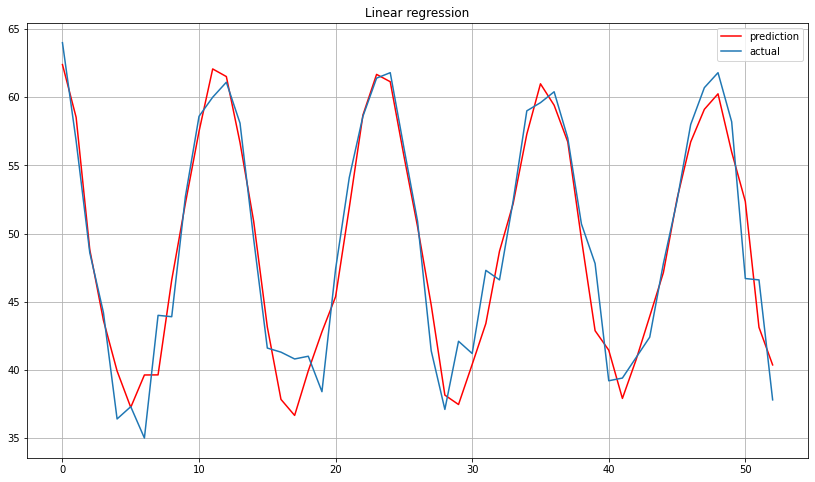

In [19]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
prediction = model_lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True)

И ***случайный лес***:

In [20]:
params = {'criterion': ['mse'],
 'max_depth': np.arange(2, 11, 2),
 'min_samples_leaf': np.arange(2, 15, 4),
 'min_samples_split': np.arange(3, 16, 5),
 'n_estimators': np.arange(10, 101, 10)
  }

In [21]:
model_rfc=RandomForestRegressor(random_state=12345)

In [22]:
%%time
grid = GridSearchCV(model_rfc, params, cv=5)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'criterion': 'mse', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 70}
Wall time: 4min 8s


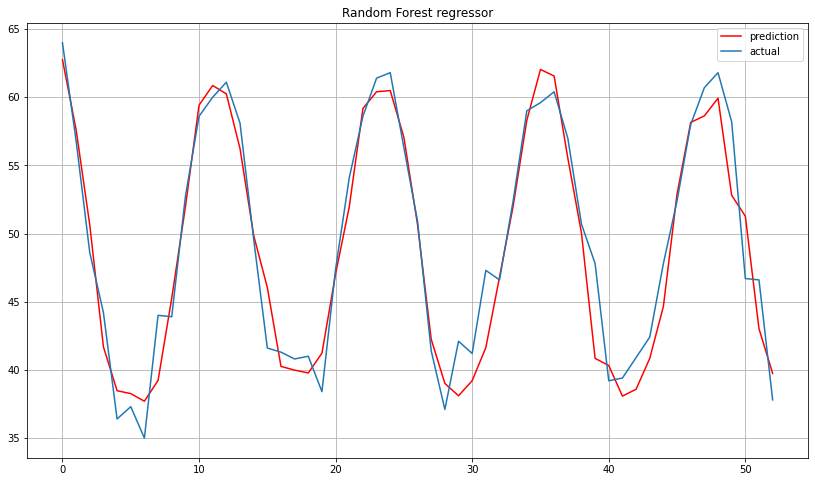

In [23]:
model_rfc=RandomForestRegressor(random_state=12345, max_depth=8, min_samples_leaf=2, min_samples_split=8, n_estimators=70)
model_rfc.fit(X_train, y_train)
pred_rf = model_rfc.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(pred_rf, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Random Forest regressor")
plt.grid(True)

Исходя из данных, представленных на графиках, можно сказать, что и линейная регрессия, и случайный лес не сильно ушли друг от друга в плане предсказаний для этого ряда. Результат схож.

### Вывод

В данной работе мы строили 2 модели: ARIMA (и в т.ч. SARIMA, которая явно моделирует сезонный элемент в одномерных данных) и GARCH.  
В процессе написания работы обе модели показали хороший результат, отвергающий гипотезу о нестационарности ряда. При этом ARIMA (и SARIMA) не требовали предобработки данных, т.к. в них дифференцирование, способствующее усилению стационарности ряда, уже заложено изначально, в то время как для GARCH было проведено преобразование Бокса-Кокса, а также убраны тренд и сезонность.

По итогу работы с моделями можно сказать, что хотя все модели справились с задачей, GARCH в нашем случае оказался предпочтительнее, потому как используемый в работе ряд сложно назвать предсказуемым. Подобно волатильности рубля, температура также была изменчива на протяжении всего представленного периода. Поэтому более достоверный прогноз мы получили именно от модели GARCH.  

На завершающем этапе мы обучили 2 классические модели: линейную регрессию и случайный лес. Классические модели также смогли предсказать температуру, но несколько хуже первых моделей.  

Таким образом, пальма первенства в данном случае принадлежит модели GARCH. При этом не будем забывать, что при другом наборе данных или при бОльшем ряде этих же данных результат мог бы поменяться.